In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
img = cv2.imread("./Jazz.jpeg")

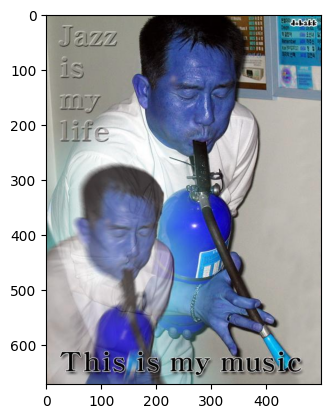

In [3]:
plt.imshow(img)

In [4]:
from utils.Interpolator import Interpolator

class ImageTransformer:
    
    def __init__(self, image):
        self.image = image.copy()
        
    def scale(self, scale_width, scale_height, interpolator):
        frame = ImageTransformer.Padder(self.image).bottom(1).end(1).build()
        
        frame_height, frame_width, frame_channel = self.image.shape
        
        new_frame_grid_height, new_frame_grid_width, new_frame_grid_channel = np.mgrid[:int(frame_height * scale_height), :int(frame_width * scale_width), :3]
        
        new_frame = np.zeros([
            int(frame_height * scale_height), 
            int(frame_width * scale_width), 
            frame_channel
        ], np.int32)
        
        new_frame_grid_height = np.reshape(new_frame_grid_height, -1)
        new_frame_grid_width = np.reshape(new_frame_grid_width, -1)
        new_frame_grid_channel = np.reshape(new_frame_grid_channel, -1)

        scaled_frame_grid_height = new_frame_grid_height * (1/scale_height)
        scaled_frame_grid_width = new_frame_grid_width * (1/scale_width)

        scaled_frame_idx_y = scaled_frame_grid_height.astype(np.int32)
        scaled_frame_idx_x = scaled_frame_grid_width.astype(np.int32)
        
        scaled_frame_shift_y = scaled_frame_grid_height - scaled_frame_idx_y
        scaled_frame_shift_x = scaled_frame_grid_width - scaled_frame_idx_x
        
        points = (frame[scaled_frame_idx_y, scaled_frame_idx_x, new_frame_grid_channel], 
                  frame[scaled_frame_idx_y+1, scaled_frame_idx_x, new_frame_grid_channel], 
                  frame[scaled_frame_idx_y, scaled_frame_idx_x+1, new_frame_grid_channel], 
                  frame[scaled_frame_idx_y+1, scaled_frame_idx_x+1, new_frame_grid_channel])

        new_frame[new_frame_grid_height, new_frame_grid_width, new_frame_grid_channel] = interpolator(
            points, 
            scaled_frame_shift_x, 
            scaled_frame_shift_y
        )

        self.image = new_frame
        return self
        
    def build(self):
        return self.image
    
    
    # ==================================== [PADDER] ====================================
    class Padder:
        '''
        이미지를 패딩해줍니다.
        빌더 패턴이며, 패딩 요소를 추가한 후 build를 호출해주세요
        '''
        def __init__(self, image):
            self.image = image.copy()

        def _horizontal_padding(self, size, direction="start"):
            '''
            [direction]
            "start" : start padding
            "end" : end padding
            else : return plain image
            '''
            temp = self.image.copy()

            h,w,c = temp.shape

            pad = np.zeros((h, size, c), temp.dtype)

            if direction == "start":
                temp = np.concatenate([pad, temp], axis=1)
            elif direction == "end":
                temp = np.concatenate([temp, pad], axis=1)

            return temp

        def _vertical_padding(self, size, direction="top"):
            '''
            [direction]
            "top" : top padding
            "bottom" : bottom padding
            else : return plain image
            '''
            temp = self.image.copy()

            h,w,c = temp.shape

            pad = np.zeros((size, w, c), temp.dtype)

            if direction == "top":
                temp = np.concatenate([pad, temp], axis=0)
            elif direction == "bottom":
                temp = np.concatenate([temp, pad], axis=0)

            return temp

        def top(self, size):
            self.image = self._vertical_padding(size, "top")
            return self

        def bottom(self, size):
            self.image = self._vertical_padding(size, "bottom")
            return self

        def start(self, size):
            self.image = self._horizontal_padding(size, "start")
            return self

        def end(self, size):
            self.image = self._horizontal_padding(size, "end")
            return self

        def build(self):
            return self.image

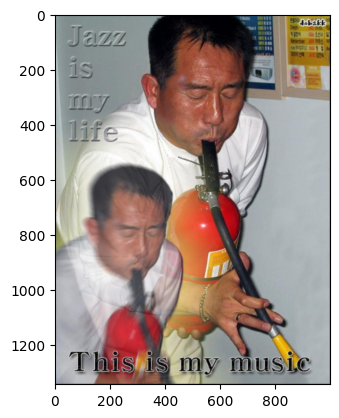

In [6]:
plt.imshow(ImageTransformer(img).scale(2,2, Interpolator.triangular).build()[...,::-1])